# Calculate X-ray telescope coverage of LoVoCCS clusters

In this notebook we use the existing LoVoCCS coverage maps, which describe how much of the sky surrounding the positions of our clusters has been observed by various X-ray telescopes, to calculate the coverage fractions for several different apertures (including the MCXC defined $R_{500}$. This is to give an idea of how well observed the clusters are by different telescopes, and highlight which ones haven't been observed at all by XMM.

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from astropy.io import fits
from shutil import rmtree
import os
from matplotlib import pyplot as plt
from tqdm import tqdm

import xga
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products.phot import ExpMap
from xga.imagetools.misc import pix_deg_scale, physical_rad_to_pix
from xga.imagetools.profile import annular_mask
from xga.sourcetools.misc import rad_to_ang

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Checking other repository is present

This notebook relies on the LoVoCCS coverage maps generated for the X-LoVoCCS-Data repository (which contains all the notebooks necessary to recreate the LoVoCCS X-ray dataset) - thus we need to ensure that the repository is where we expect it to be before this notebook continues (this is mostly in case anyone ever wishes to recreate all of our analyses):

In [2]:
if not os.path.exists("../../../X-LoVoCCS-Data/"):
    raise FileNotFoundError("We require the X-LoVoCCS-Data repository to be cloned into the same directory as "\
                            "the X-LoVoCCS-Analyses directory.")
else:
    cov_map_path = "../../../X-LoVoCCS-Data/outputs/coverage_maps/fits/"

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [3]:
if not os.path.exists("../../outputs/results/"):
    os.makedirs("../../outputs/results/")
    
if not os.path.exists("../../outputs/figures/coverage_fractions/"):
    os.makedirs("../../outputs/figures/coverage_fractions/")

## Defining cosmology

We define the cosmology we're using for our analysis, which is concordance LambdaCDM (the default for XGA):

In [4]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Define useful functions

Here we define any functions to be used in this notebook - for this particular analysis this means the function that can mask a coverage map and calculate how much the defined region has been covered by observations by different X-ray telescopes:

In [5]:
def cov_calc(rel_row, extra_apertures=None, show_mask_cov_maps=False) -> dict:
    cur_name = rel_row["LoVoCCS_name"]
    cov_file_lov_name = cur_name if cur_name[-1].isdigit() else cur_name[:-1]
    
    cov_path = os.path.join(cov_map_path, "{n}_550pix_20.0arcsec.fits".format(n=cov_file_lov_name))
    cur_cheese = ExpMap(cov_path, '', '', '', '', '', Quantity(0.5, 'keV'), Quantity(2.0, 'keV'))
    
    # This is what we store our coverage fraction measurements in - top level keys are mission names, lower
    #  level keys are the radii
    all_cov_frac = {}
    
    with fits.open(cov_path) as covero:
        cov_arr = covero[0].data
        
        # Iterating through the different missions, each has a different layer in the 3D array that is cov_arr 
        for miss_ind, miss_head_name in enumerate(covero[0].header['MISSION*']):
            # This retrieves the name of the current mission
            cur_miss = covero[0].header[miss_head_name]
            # Add a dictionary to contain the various coverage fractions we measure for this mission
            all_cov_frac[cur_miss] = {}
            # Grab just the coverage map for the one current mission
            cur_cov_arr = cov_arr[miss_ind, :, :]
            cur_cheese._data = cur_cov_arr
            cur_cheese._shape = cur_cov_arr.shape
            cur_cheese.src_name = cur_name + " " + cur_miss
            
            # Get the best central position - in the cases where the 'manual_xray_*' columns are NaN, then
            #  the MCXC one is fine to start with
            if not np.isnan(rel_row['manual_xray_ra']):
                deg_cen = Quantity(rel_row[['manual_xray_ra', 'manual_xray_dec']], 'deg')
            else:
                deg_cen = Quantity(rel_row[['MCXC_RA', 'MCXC_DEC']], 'deg')
            pix_cen = cur_cheese.coord_conv(deg_cen, 'pix')
            
            # The one guaranteed aperture we'll be using, the MCXC R500 value
            cur_r500 = Quantity(rel_row['MCXC_R500'], 'Mpc')
            apertures = [cur_r500]
            # But if a list of other apertures was passed we'll use them too - doing it this way we ensure that 
            #  R500 is the first entry, which is good because we'll add it to the dictionary under the 
            #  "R500" key rather than the quantity
            if extra_apertures is not None:
                apertures += extra_apertures
            apertures = Quantity(apertures)
            
            # Iterate through the aperture radii
            for ap_ind, ap in enumerate(apertures):
                # Use the WCS information in the coverage map (and an XGA exposure map/XGA function) to
                #  convert the kpc/Mpc radii into pixels valid for the size of the coverage map pixels
                # Also need the redshift of the cluster, and the chosen cosmology
                pix_ap = physical_rad_to_pix(cur_cheese, ap, pix_cen, rel_row['MCXC_Redshift'], cosmo)
                
                # Then use another XGA function to setup a circular mask of radius 'pix_ap'
                ap_mask = annular_mask(pix_cen, np.array([0]), np.array([pix_ap.value]), cur_cov_arr.shape)
                
                # If requested, we can show the masked coverage map
                if show_mask_cov_maps:
                    cur_cheese.view(pix_cen, ap_mask)
                    plt.close('all')
                    
                # Then we mask the coverage map
                msk_cur_cov = cur_cov_arr*ap_mask
                # And calculate the coverage fraction
                cur_cov_frac = (msk_cur_cov.sum() / ap_mask.sum()).round(2)
                
                if ap_ind == 0:
                    all_cov_frac[cur_miss]['MCXC_R500'] = cur_cov_frac
                else:
                    all_cov_frac[cur_miss][ap] = cur_cov_frac
            
    return all_cov_frac

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [6]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-"+str(x))
samp

,LoVoCCSID,Name,MCXC_RA,MCXC_DEC,MCXC_Redshift,manual_xray_ra,manual_xray_dec,MCXC_R500,LoVoCCS_name
0,1,A2029,227.73000,5.720000,0.0766,227.734300,5.745471,1.3344,LoVoCCS-1
1,2,A401,44.74000,13.580000,0.0739,NaN,NaN,1.2421,LoVoCCS-2
2,4,A85,10.45875,-9.301944,0.0555,NaN,NaN,1.2103,LoVoCCS-4
3,5,A3667,303.13000,-56.830000,0.0556,303.157313,-56.845978,1.1990,LoVoCCS-5
4,7,A3827,330.48000,-59.950000,0.0980,NaN,NaN,1.1367,LoVoCCS-7
...,...,...,...,...,...,...,...,...,...
61,121,A3128,52.50000,-52.600000,0.0624,52.466189,-52.580728,0.8831,LoVoCCS-121
62,122,A1023,157.00000,-6.800000,0.1176,NaN,NaN,0.8553,LoVoCCS-122
63,123,A3528,193.67000,-29.220000,0.0544,NaN,NaN,0.8855,LoVoCCS-123
64,131,A761,137.65125,-10.581111,0.0916,NaN,NaN,0.8627,LoVoCCS-131


## Calculate coverage fraction

We iterate through the clusters in our sample, and run the coverage fraction calculation function - this uses the existing LoVoCCS coverage maps (see the X-LoVoCCS-Data repository) to measure what fraction of several different apertures, centered on the LoVoCCS starting coordinate (be it the original MCXC or a manually adjusted one), have been observed by different telescopes.

The MCXC $R_{500}$ aperture is tested by default, along with the aperture radii we define in the function calls below:

In [7]:
oth_ap_rad = [Quantity(300, 'kpc'), Quantity(500, 'kpc'), Quantity(1000, 'kpc'), Quantity(2000, 'kpc')]

In [8]:
lovoccs_cov_fracs = {}
with tqdm(desc="Calculating coverage fractions", total=len(samp)) as onwards:
    for row_ind, row in samp.iterrows():
        cov_info = cov_calc(row, oth_ap_rad, show_mask_cov_maps=False)
        # We strip out the results for RASS, as they are a) unnecessary, and b) unreliable with a particular 
        #  of the coverage maps as we oversampled the pixel scale of the RASS exposure maps
        del cov_info['rosat_all_sky']
        lovoccs_cov_fracs[row['LoVoCCS_name']] = cov_info
        onwards.update(1)

Calculating coverage fractions: 100%|██████████| 66/66 [00:33<00:00,  1.99it/s]


## Save coverage fractions to file

We make sure to save a file (csv) containing the coverage fractions - each mission and aperture combination gets its own column:

In [9]:
for_df = {n: {mn+"_"+str(apn).replace(" ", ""): tfs[mn][apn] for mn in tfs for apn in tfs[mn]} 
          for n, tfs in lovoccs_cov_fracs.items()}
cov_df = pd.DataFrame.from_dict(for_df, orient='index')
cov_df.to_csv("../../outputs/results/mission_coverage_fractions.csv", index=False)
cov_df

,xmm_pointed_MCXC_R500,xmm_pointed_0.3Mpc,xmm_pointed_0.5Mpc,xmm_pointed_1.0Mpc,xmm_pointed_2.0Mpc,chandra_MCXC_R500,chandra_0.3Mpc,chandra_0.5Mpc,chandra_1.0Mpc,chandra_2.0Mpc,rosat_pointed_pspc_MCXC_R500,rosat_pointed_pspc_0.3Mpc,rosat_pointed_pspc_0.5Mpc,rosat_pointed_pspc_1.0Mpc,rosat_pointed_pspc_2.0Mpc,rosat_pointed_hri_MCXC_R500,rosat_pointed_hri_0.3Mpc,rosat_pointed_hri_0.5Mpc,rosat_pointed_hri_1.0Mpc,rosat_pointed_hri_2.0Mpc,nustar_pointed_MCXC_R500,nustar_pointed_0.3Mpc,nustar_pointed_0.5Mpc,nustar_pointed_1.0Mpc,nustar_pointed_2.0Mpc,swift_xrt_MCXC_R500,swift_xrt_0.3Mpc,swift_xrt_0.5Mpc,swift_xrt_1.0Mpc,swift_xrt_2.0Mpc,asca_MCXC_R500,asca_0.3Mpc,asca_0.5Mpc,asca_1.0Mpc,asca_2.0Mpc
LoVoCCS-1,1.00,1.0,1.0,1.00,0.97,1.00,1.0,1.00,1.00,0.94,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.0,1.0,1.0,1.0,0.94,0.82,1.00,1.00,1.00,0.52,1.00,1.0,1.0,1.0,0.88
LoVoCCS-2,1.00,1.0,1.0,1.00,0.98,1.00,1.0,1.00,1.00,0.91,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.00,1.00,0.0,0.0,0.0,0.0,0.00,1.00,1.00,1.00,1.00,0.99,1.00,1.0,1.0,1.0,0.94
LoVoCCS-4,0.99,1.0,1.0,1.00,0.87,1.00,1.0,1.00,1.00,0.93,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.00,0.99,0.0,0.0,0.0,0.0,0.00,0.52,1.00,1.00,0.76,0.22,0.99,1.0,1.0,1.0,0.54
LoVoCCS-5,1.00,1.0,1.0,1.00,0.82,0.97,1.0,1.00,0.99,0.67,1.0,1.0,1.0,1.00,1.00,1.00,1.0,1.0,1.00,0.99,0.0,0.0,0.0,0.0,0.00,0.27,0.15,0.24,0.28,0.21,0.97,1.0,1.0,1.0,0.78
LoVoCCS-7,1.00,1.0,1.0,1.00,0.98,0.70,1.0,1.00,0.77,0.46,0.0,0.0,0.0,0.00,0.00,1.00,1.0,1.0,1.00,1.00,0.0,0.0,0.0,0.0,0.00,0.34,0.19,0.30,0.35,0.30,0.00,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LoVoCCS-121,1.00,1.0,1.0,1.00,0.44,0.79,1.0,0.96,0.72,0.22,1.0,1.0,1.0,1.00,0.99,1.00,1.0,1.0,1.00,0.99,0.0,0.0,0.0,0.0,0.00,0.02,0.00,0.00,0.04,0.14,0.00,0.0,0.0,0.0,0.00
LoVoCCS-122,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00
LoVoCCS-123,0.97,1.0,1.0,0.95,0.57,0.99,1.0,1.00,0.96,0.72,1.0,1.0,1.0,1.00,1.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.81,0.99,0.95,0.80,0.72,1.00,1.0,1.0,1.0,0.49
LoVoCCS-131,1.00,1.0,1.0,1.00,0.59,0.00,0.0,0.00,0.00,0.00,1.0,1.0,1.0,0.98,0.78,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00


## Which LoVoCCS sample members have limited/no XMM coverage?

We can now use the coverage dataframe to easily identify those members of the current LoVoCCS sample that have severely limited XMM coverage (we care particularly about XMM as it is the main telescope for the current work).

This shows us that three of the current sample have no XMM coverage at all:

In [10]:
cov_df[cov_df['xmm_pointed_MCXC_R500'] < 0.5]

,xmm_pointed_MCXC_R500,xmm_pointed_0.3Mpc,xmm_pointed_0.5Mpc,xmm_pointed_1.0Mpc,xmm_pointed_2.0Mpc,chandra_MCXC_R500,chandra_0.3Mpc,chandra_0.5Mpc,chandra_1.0Mpc,chandra_2.0Mpc,rosat_pointed_pspc_MCXC_R500,rosat_pointed_pspc_0.3Mpc,rosat_pointed_pspc_0.5Mpc,rosat_pointed_pspc_1.0Mpc,rosat_pointed_pspc_2.0Mpc,rosat_pointed_hri_MCXC_R500,rosat_pointed_hri_0.3Mpc,rosat_pointed_hri_0.5Mpc,rosat_pointed_hri_1.0Mpc,rosat_pointed_hri_2.0Mpc,nustar_pointed_MCXC_R500,nustar_pointed_0.3Mpc,nustar_pointed_0.5Mpc,nustar_pointed_1.0Mpc,nustar_pointed_2.0Mpc,swift_xrt_MCXC_R500,swift_xrt_0.3Mpc,swift_xrt_0.5Mpc,swift_xrt_1.0Mpc,swift_xrt_2.0Mpc,asca_MCXC_R500,asca_0.3Mpc,asca_0.5Mpc,asca_1.0Mpc,asca_2.0Mpc
LoVoCCS-33,0.37,0.26,0.34,0.37,0.36,1.00,1.0,1.0,1.00,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.88,0.99,0.97,0.89,0.71,0.53,0.61,0.54,0.52,0.54,0.0,0.00,0.00,0.0,0.00
LoVoCCS-41C,0.22,0.00,0.07,0.22,0.26,0.94,1.0,1.0,0.94,0.64,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99,0.00,0.00,0.00,0.00,0.00,0.54,0.90,0.72,0.54,0.44,0.4,0.31,0.36,0.4,0.37
LoVoCCS-55,0.00,0.00,0.00,0.00,0.00,1.00,1.0,1.0,1.00,0.92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
LoVoCCS-108,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00
LoVoCCS-122,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00


## Coverage distributions

We wish to visualise different mission's coverage fractions of our LoVoCCS sample - we shall do this using histograms (including several different apertures to give some context). We start by defining the colours for each apertures:

In [11]:
r500_col = 'tab:cyan'
const_05mpc_col = 'firebrick'
const_1mpc_col = 'black'

Then we setup the bins, choosing a bin size of 0.025:

In [12]:
cov_bins = np.linspace(0, 1, 41)
cov_bins

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   ])

### XMM-Newton Pointed

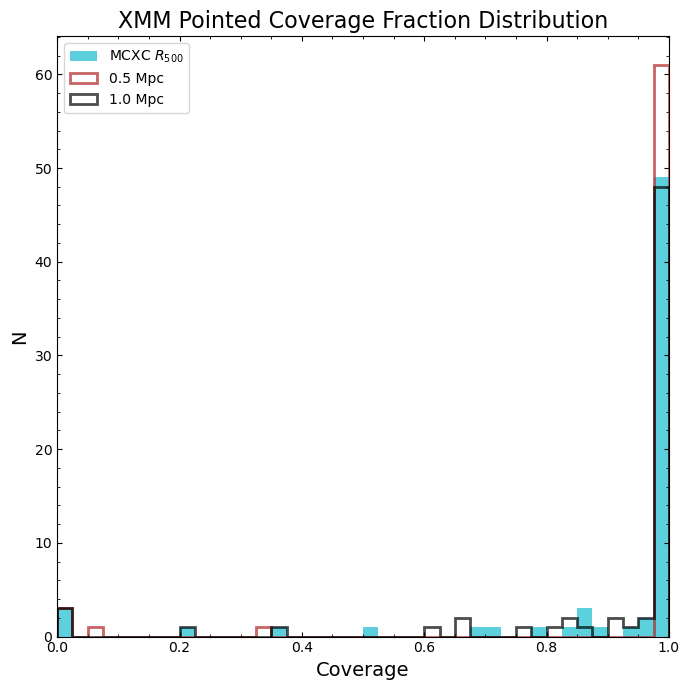

In [13]:
plt.figure(figsize=(7, 7))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.hist(cov_df['xmm_pointed_MCXC_R500'], bins=cov_bins, label=r"MCXC $R_{500}$", color=r500_col, alpha=0.7, 
         histtype="stepfilled")
plt.hist(cov_df['xmm_pointed_0.5Mpc'], bins=cov_bins, label=r"0.5 Mpc", color=const_05mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)
plt.hist(cov_df['xmm_pointed_1.0Mpc'], bins=cov_bins, label=r"1.0 Mpc", color=const_1mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)

plt.title("XMM Pointed Coverage Fraction Distribution", fontsize=16)
plt.ylabel("N", fontsize=14)
plt.xlabel("Coverage", fontsize=14)

plt.xlim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("../../outputs/figures/coverage_fractions/xmmpointed_coverage.pdf")
plt.show()

### Chandra

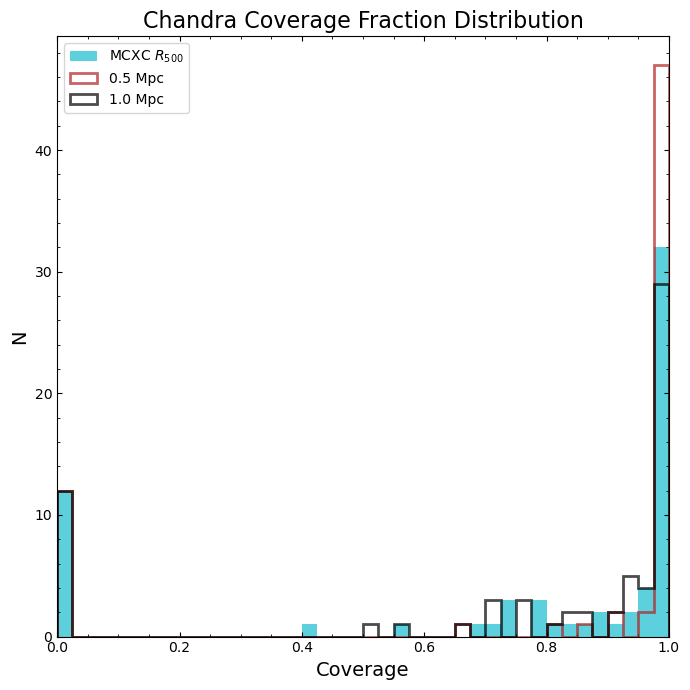

In [14]:
plt.figure(figsize=(7, 7))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.hist(cov_df['chandra_MCXC_R500'], bins=cov_bins, label=r"MCXC $R_{500}$", color=r500_col, alpha=0.7, 
         histtype="stepfilled")
plt.hist(cov_df['chandra_0.5Mpc'], bins=cov_bins, label=r"0.5 Mpc", color=const_05mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)
plt.hist(cov_df['chandra_1.0Mpc'], bins=cov_bins, label=r"1.0 Mpc", color=const_1mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)

plt.title("Chandra Coverage Fraction Distribution", fontsize=16)
plt.ylabel("N", fontsize=14)
plt.xlabel("Coverage", fontsize=14)

plt.xlim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("../../outputs/figures/coverage_fractions/chandra_coverage.pdf")
plt.show()

### NuSTAR

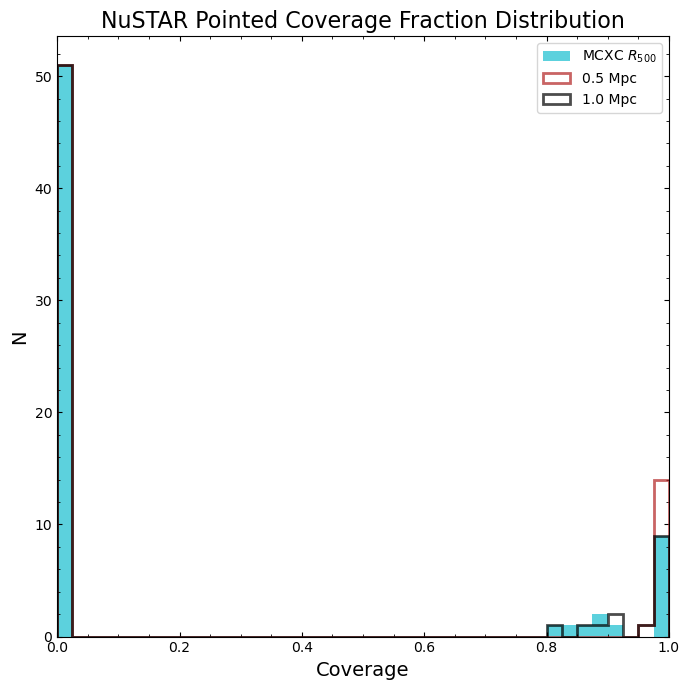

In [15]:
plt.figure(figsize=(7, 7))
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.hist(cov_df['nustar_pointed_MCXC_R500'], bins=cov_bins, label=r"MCXC $R_{500}$", color=r500_col, alpha=0.7, 
         histtype="stepfilled")
plt.hist(cov_df['nustar_pointed_0.5Mpc'], bins=cov_bins, label=r"0.5 Mpc", color=const_05mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)
plt.hist(cov_df['nustar_pointed_1.0Mpc'], bins=cov_bins, label=r"1.0 Mpc", color=const_1mpc_col, alpha=0.7, 
         histtype="step", linewidth=2.)

plt.title("NuSTAR Pointed Coverage Fraction Distribution", fontsize=16)
plt.ylabel("N", fontsize=14)
plt.xlabel("Coverage", fontsize=14)

plt.xlim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.savefig("../../outputs/figures/coverage_fractions/nustarpointed_coverage.pdf")
plt.show()